# Part 1: Data Preparation & Embeddings (Flickr8k + CLIP)

**Goal:** 
- Load the Flickr8k dataset (images + captions)
- Use a pretrained multimodal model (CLIP) from Hugging Face
- Generate **image** and **text** embeddings
- Save embeddings and metadata for later search

**Outputs saved to**: `../embeddings/`

In [ ]:
# Imports & Config

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from IPython.display import display


from transformers import CLIPProcessor, CLIPModel

# Paths
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]
DATA_DIR = PROJECT_ROOT / "data" / "flickr8k"
IMAGES_DIR = DATA_DIR / "Images"
CAPTIONS_FILE = DATA_DIR / "captions.txt"

EMB_DIR = PROJECT_ROOT / "embeddings"
EMB_DIR.mkdir(parents=True, exist_ok=True)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


c:\Nackademin_PIA_24\deep_learning\search_engine\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [2]:
# Sanity checks (paths & files)

assert IMAGES_DIR.exists(), f"Images folder not found: {IMAGES_DIR}"
assert CAPTIONS_FILE.exists(), f"Captions file not found: {CAPTIONS_FILE}"

len(list(IMAGES_DIR.glob("*.jpg")))


8091

In [5]:
# Load captions into a DataFrame

from pathlib import Path
import pandas as pd
import re

def load_captions_flexible(captions_path: Path) -> pd.DataFrame:
    """
    Tries multiple common formats:
    1) Flickr8k.token.txt style:
       'image.jpg#0<TAB or SPACE>Caption text ...'
    2) CSV with two columns: image,caption
    """
    rows = []
    with open(captions_path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue

            # Try CSV (image,caption)
            if "," in line and not line.startswith("#"):
                # Heuristic: if there's exactly one comma and the left token looks like a filename
                left, right = line.split(",", 1)
                if left.lower().endswith((".jpg", ".jpeg", ".png")):
                    rows.append({"image": left.strip(), "caption": right.strip()})
                    continue

            # Flickr8k.token.txt style (filename#idx + space or tab + caption)
            if "\t" in line:
                left, caption = line.split("\t", 1)
            else:
                # split on first whitespace
                parts = line.split(maxsplit=1)
                if len(parts) < 2:
                    # malformed line, skip
                    continue
                left, caption = parts[0], parts[1]

            image_name = left.split("#", 1)[0].strip()
            rows.append({"image": image_name, "caption": caption.strip()})

    df = pd.DataFrame(rows)
    if df.empty or not set(["image", "caption"]).issubset(df.columns):
        raise ValueError(
            f"Could not parse any (image, caption) pairs from {captions_path}. "
            "Open the file and inspect the format."
        )
    return df

captions_df = load_captions_flexible(CAPTIONS_FILE)
print(captions_df.shape)
captions_df.head()



(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


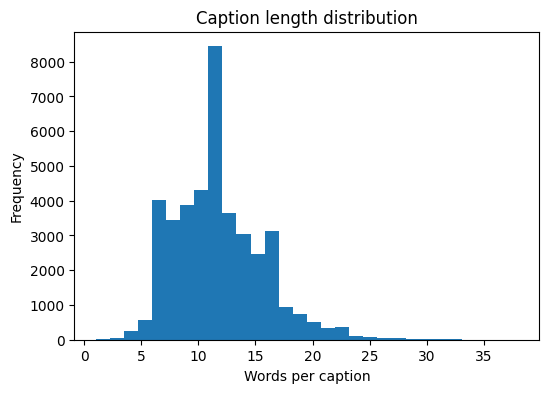

Unique images: 8091
Total captions: 40455


In [6]:
# Basic EDA graphs

# Caption length distribution
caption_lengths = captions_df["caption"].str.split().apply(len)

plt.figure(figsize=(6,4))
plt.hist(caption_lengths, bins=30)
plt.title("Caption length distribution")
plt.xlabel("Words per caption")
plt.ylabel("Frequency")
plt.show()

print("Unique images:", captions_df["image"].nunique())
print("Total captions:", len(captions_df))


In [7]:
# Deduplicate to one caption per image

# For building an image embedding index, it's typical to keep one caption per image.
# Strategy: pick the first caption per image.
one_caption_df = (captions_df
                  .groupby("image", as_index=False)
                  .first()
                 ).reset_index(drop=True)

print("Images after dedup:", len(one_caption_df))
one_caption_df.head()


Images after dedup: 8091


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [8]:
# CLIP model & processor (Hugging Face)

MODEL_NAME = "openai/clip-vit-base-patch32"

clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME)

# Put model in eval mode
clip_model.eval()

# Quick parameter count (sanity)
total_params = sum(p.numel() for p in clip_model.parameters())
total_params


c:\Nackademin_PIA_24\deep_learning\search_engine\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kenda\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falli

151277313

In [10]:
# PyTorch Dataset for images

class FlickrImageDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, images_dir: Path):
        self.df = dataframe.reset_index(drop=True)
        self.images_dir = images_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = self.images_dir / row["image"]
        image = Image.open(img_path).convert("RGB")
        caption = row["caption"]
        return {
            "image": image,
            "caption": caption,
            "image_name": row["image"],
        }

image_ds = FlickrImageDataset(one_caption_df, IMAGES_DIR)
len(image_ds), image_ds[0]["image"].size


(8091, (375, 500))

In [11]:
# DataLoader & batching utilities

BATCH_SIZE = 64

def collate_fn(batch):
    images = [b["image"] for b in batch]
    captions = [b["caption"] for b in batch]
    image_names = [b["image_name"] for b in batch]
    return images, captions, image_names

image_dl = DataLoader(image_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
len(image_dl)


127

In [12]:
# Compute image embeddings (batched, with tqdm)

@torch.no_grad()
def compute_image_embeddings(dataloader, model, processor, device="cpu"):
    all_embs = []
    all_names = []
    for images, captions, names in tqdm(dataloader, desc="Embedding images"):
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**inputs)  # [B, D]
        # Normalize to unit length (recommended for cosine similarity later)
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        all_embs.append(image_features.cpu().numpy())
        all_names.extend(names)
    embs = np.concatenate(all_embs, axis=0)
    return embs, all_names

image_embs, image_names = compute_image_embeddings(image_dl, clip_model, clip_processor, device=DEVICE)
image_embs.shape, len(image_names)


Embedding images: 100%|██████████| 127/127 [11:26<00:00,  5.41s/it]


((8091, 512), 8091)

In [13]:
# Save image embeddings + metadata

# Save a single matrix for all images and a CSV mapping (image_name -> caption)
np.save(EMB_DIR / "image_embeddings.npy", image_embs)

meta_df = one_caption_df.copy()
meta_df.to_csv(EMB_DIR / "metadata.csv", index=False)

print("Saved:", EMB_DIR / "image_embeddings.npy")
print("Saved:", EMB_DIR / "metadata.csv")


Saved: c:\Nackademin_PIA_24\deep_learning\search_engine\embeddings\image_embeddings.npy
Saved: c:\Nackademin_PIA_24\deep_learning\search_engine\embeddings\metadata.csv


In [14]:
# Sanity check: nearest neighbors for a sample caption vs image index

from sklearn.metrics.pairwise import cosine_similarity

@torch.no_grad()
def embed_text_prompts(prompts, model, processor, device="cpu"):
    inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    text_features = model.get_text_features(**inputs)  # [B, D]
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    return text_features.cpu().numpy()

# Pick a random caption as a query
sample_caption = one_caption_df.sample(1, random_state=42)["caption"].item()
sample_caption


'"A black-and-white dog bounds off the ground , all feet in the air , of a yellow field ."'

In [15]:
# Compute similarity & show top-5 image names

text_emb = embed_text_prompts([sample_caption], clip_model, clip_processor, device=DEVICE)  # [1, D]
sims = cosine_similarity(text_emb, image_embs)[0]  # [N_images]

topk = 5
top_idx = np.argsort(sims)[::-1][:topk]
list(zip([image_names[i] for i in top_idx], sims[top_idx]))


[('3164328039_2c56acf594.jpg', np.float32(0.33809897)),
 ('2713897716_c8cd610360.jpg', np.float32(0.33011156)),
 ('3139895886_5a6d495b13.jpg', np.float32(0.3283577)),
 ('3025546819_ce031d2fc3.jpg', np.float32(0.32693166)),
 ('2854959952_3991a385ab.jpg', np.float32(0.3242076))]

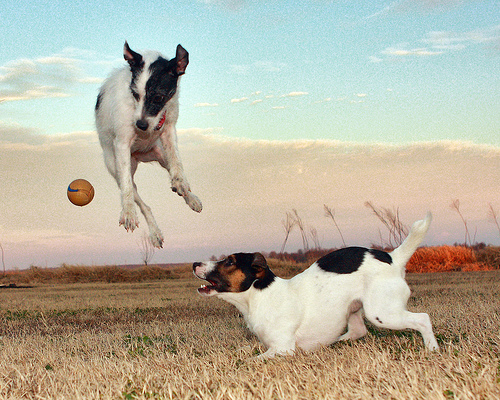

('3164328039_2c56acf594.jpg', None)

In [16]:
# Visualize the top result

def show_image(image_name: str):
    img_path = IMAGES_DIR / image_name
    display(Image.open(img_path).convert("RGB"))

# Show the best match for the sample caption
best_name = image_names[top_idx[0]]
best_name, show_image(best_name)


# Wrap-up: what we produced

### Outputs produced in this notebook

- `../embeddings/image_embeddings.npy` — image embedding matrix of shape `[num_images, dim]` (L2-normalized).
- `../embeddings/metadata.csv` — mapping of image file names to a single caption (one per image).

These files will be used in **Part 2** to implement text-to-image search (top-5 matches by cosine similarity).
